In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name())

True
1
0
NVIDIA GeForce RTX 2060 with Max-Q Design


In [4]:
train_dataset = torchvision.datasets.FashionMNIST('data/', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST('data/', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, shuffle=True, batch_size=100)

In [6]:
label_list = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
label_map = dict(zip(range(10), label_list))
print(label_map)

{0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}


In [7]:
print(train_dataset)
print(test_dataset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [8]:
len(train_dataset), type(train_dataset[0]), train_dataset[0][0].shape, train_dataset[0][0][0].shape, train_dataset[0][1]

(60000, tuple, torch.Size([1, 28, 28]), torch.Size([28, 28]), 9)

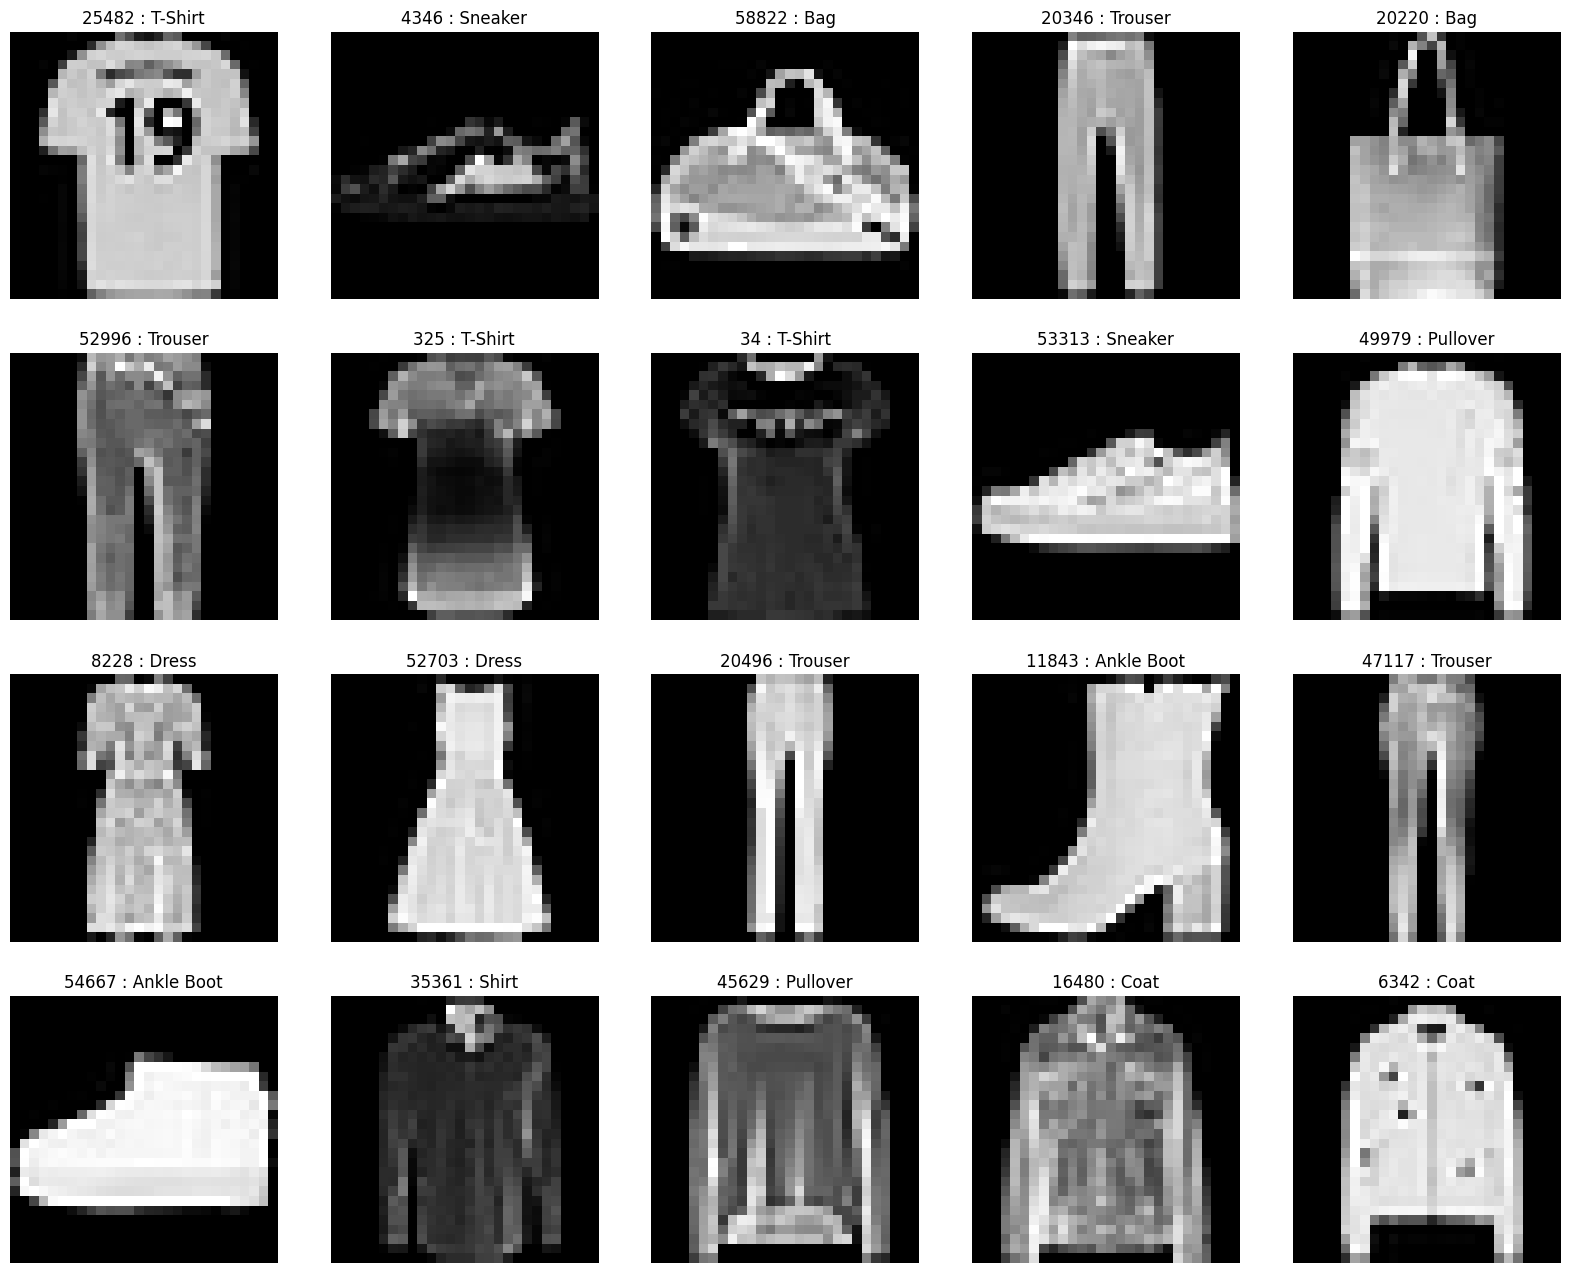

In [9]:
fig = plt.figure(figsize=(20, 16))
columns, rows = 5, 4

for i in range(1, columns*rows+1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0, :, :]
    fig.add_subplot(rows, columns, i)
    plt.title(str(img_xy) + " : " + label_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    
plt.show()

##### Deep Neural Network Model for FashionMNIST

In [ ]:
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()    # super().__init__()과 같다. 자식클래스(FashionDNN)가 상속받는 부모클래스(nn.Module)를 자식클래스(FashionDNN)에 불러오겠습니다.
        